# Pokemon GAN Training Notebook

## **Import libraries**

In [1]:
import sys
sys.path.append('../sources')

In [2]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from dataset import PokemonGensDataset
from WACGAN import WACGAN
import utils as ut
import variable as var
import os
import cuda_monitoring as cuda_mon
import matplotlib.pyplot as plt
import numpy as np
import warnings

In [3]:
import torchvision.utils as vutils

In [4]:
cuda_mon.get_tensor_info()
cuda_mon.get_gpu_memory_info()

/home/benoit/anaconda3/lib/python3.7/site-packages/torch/distributed/distributed_c10d.py:144: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


total    : 7.77 GB
free     : 7.44 GB
used     : 343.12 MB	(4.5%)


## **Load DATASET**

In [5]:
resume_training = True
train_number = 'example_colorpicker_3'
gan_id = f"wacgan_pokemon_train_{train_number}"

greyscale = False
resize_image_dim = 64
n_conv_block = 3
batch_size = 64
label_name = 'type_12'
normalize_input = 'min_max_scale'

print(f"Greyscale: {greyscale}")
print(f"Real: {resize_image_dim}x{resize_image_dim} images")
print(f"Fake: {2**(3 + n_conv_block)}x{2**(3 + n_conv_block)} images")

Greyscale: False
Real: 64x64 images
Fake: 64x64 images


In [6]:
dset = PokemonGensDataset(label_name=label_name, greyscale=greyscale, normalize=normalize_input,
                          resize=[resize_image_dim, resize_image_dim], 
                          gens_to_remove=("gen8", "gen7", "gen6", "gen1"))
dloader = DataLoader(dset, batch_size=batch_size, shuffle=True, num_workers=0)
print(f'dataset: {len(dset)} images')

dataset: 3941 images


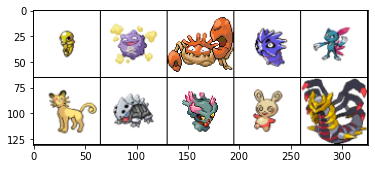

array([['grass-bug', 'poison', 'water-ice', 'ground-rock',
        'psychic-ghost-dark'],
       ['normal-fighting', 'steel', 'psychic-ghost-dark',
        'normal-fighting', 'psychic-ghost-dark']], dtype='<U18')

In [7]:
images, labels = next(iter(dloader))
ut.show_images_grid(images)
np.array([dset.label_id_to_label_name[i] for i in labels[:10].tolist()]).reshape(2, 5)

apply weights on inputs based on element wise auxiliary own class probability prediction
to do: in the generator loss function, multiply each sample-loss-value (torch.NLLLoss) value by its own class probability given by the discriminator. 


## **GAN Component**

In [8]:
gen_lr = 9e-4
crit_lr = 9e-4
gen_betas = {'1': .5, '2': .999}
crit_betas = {'1': .5, '2': .999}
n_channel = 1 if greyscale else 3
n_feature = 20 # example has 20
z_dim = 60
n_classes = len(dset.label_id_to_label_name)
use_inception = True
embedding = True
generator_type = 'color_picker'

params = {'gen': {'n_feature': n_feature,
                  'n_channel': n_channel,
                  'lr': gen_lr,
                  'betas': gen_betas,
                  'embedding': embedding},
          'critic': {'n_channel': n_channel,
                   'n_feature': n_feature,
                   'lr': crit_lr,
                   'betas': crit_betas},
          'z_dim': z_dim,
          'n_conv_block': n_conv_block,
          'n_classes': n_classes,
          'dataset': dset.describe(),
          'batch_size': batch_size,
          'use_inception': use_inception,
          'gradient_penalty_factor': 10,
          'stability_noise_std': 1e-2,
          'generator_type': generator_type
         }

## **GAN INIT AND TRAINING**

In [9]:
gan = WACGAN(params)
checkpoint_path = os.path.join(var.PROJECT_DIR, f'data/models/{gan_id}.pth')
if os.path.exists(checkpoint_path):
    print('RESUMING TRAINING...')
    gan.load_model(checkpoint_path)
else:
    print('NEW TRAINING...')
print(f'id: {gan_id}')

NEW TRAINING...
id: wacgan_pokemon_train_example_colorpicker_3


In [10]:
gan.init_tensorboard(main_dir='runs', subdir=gan_id, port=8008)

In [11]:
gan.train(n_epoch=650, n_critic_update=4, dataloader=dloader, gan_id=gan_id)

100%|██████████| 650/650 [3:22:55<00:00, 18.73s/it]  


**Auxiliary based Viz**

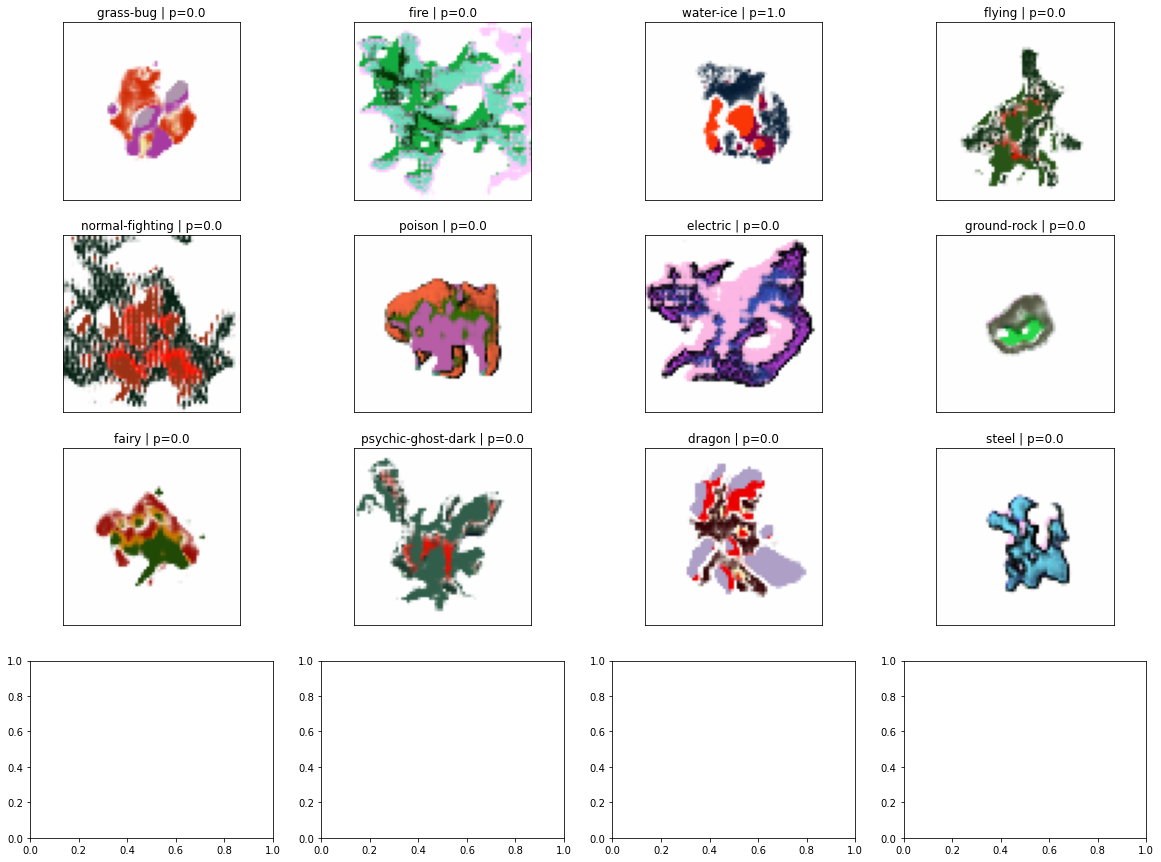

In [40]:
being_class = 9
n = 1
noise = - torch.ones(n, z_dim, 1, 1, device=var.device) 
noise = gan.get_random_noise(n)
n_label = len(dset.label_id_to_label_name)
n_label_per_row = 4
n_label_per_col = (n_label // n_label_per_row) + 1
fig, axes = plt.subplots(figsize=(20, 3 * 5) , nrows=n_label_per_row, 
                                 ncols=n_label_per_col)
for idx, (label_id, label_name) in enumerate(dset.label_id_to_label_name.items()):
    with torch.no_grad():
        classes = torch.ones((n, ), device=var.device).long() * label_id
        gan.generator.eval()
        fakes = gan.generator.forward(noise, classes)
        _, aux = gan.critic(fakes)
        
    i = idx // n_label_per_col
    j = idx % n_label_per_col
    with warnings.catch_warnings():
        fakes_grid = ut.images_grid(fakes[0], tensorboard=False)
        axes[i][j].imshow(fakes_grid)
    axes[i][j].set_title(f"{dset.label_id_to_label_name[label_id]} | p={aux.squeeze()[label_id].item()}")
    axes[i][j].xaxis.set_visible(False)
    axes[i][j].yaxis.set_visible(False)
    

**Noise based viz**

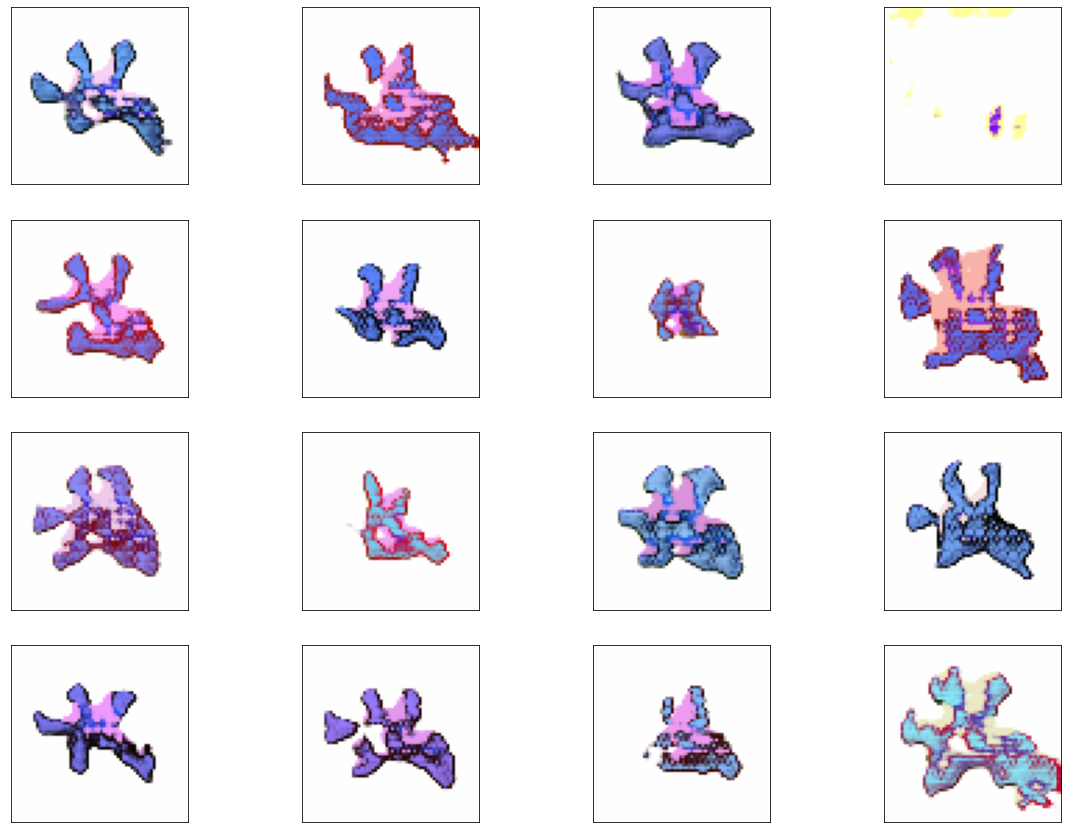

In [60]:
being_class = 1 # np.random.randint(10)
n = 1
base_noise = gan.get_random_noise(n)
# base_noise = torch.ones_like(base_noise)
n_row = 4
n_col = 4
fig, axes = plt.subplots(figsize=(20, 3 * 5) , nrows=n_row, 
                                 ncols=n_col)
for ax in axes.reshape(-1):
    noise = base_noise + (torch.randn_like(base_noise))/2
    with torch.no_grad():
        classes = torch.ones((n, ), device=var.device).long() * being_class
        gan.generator.eval()
        fakes = gan.generator.forward(noise, classes)
    fakes_grid = ut.images_grid(fakes[0], tensorboard=False)
    ax.imshow(fakes_grid)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

In [353]:
label_id

11

In [123]:
.shape

torch.Size([10])

In [126]:
aux.squeeze()[label_id].item()

0.0

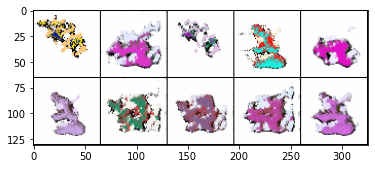

serpentine
with_fins
head_only
bipedal_tailed
head_only
with_fins
multiple_bodies
head_only
multiple_bodies
wings


In [95]:
fake, labels = gan.generate_fake(10, train=False)
ut.show_images_grid(fake)
for label in labels:
    print(dset.label_id_to_label_name[label.item()])

In [301]:
from matplotlib.lines import Line2D

def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    max_max_grad = 0.0
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            max_grad = p.grad.abs().max()
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(max_grad)
            max_max_grad = max_grad.item() if max_grad.item() > max_max_grad else max_max_grad
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=.1) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    print(max_grads)

[tensor(5.6651, device='cuda:0'), tensor(37.1417, device='cuda:0'), tensor(1.7497, device='cuda:0'), tensor(30.0315, device='cuda:0'), tensor(0.9447, device='cuda:0'), tensor(10.2452, device='cuda:0'), tensor(0.7397, device='cuda:0'), tensor(5.7435, device='cuda:0'), tensor(1.0466, device='cuda:0'), tensor(3.3919, device='cuda:0'), tensor(0.4834, device='cuda:0'), tensor(2.8198, device='cuda:0'), tensor(0.4163, device='cuda:0'), tensor(4.1677, device='cuda:0'), tensor(0.4484, device='cuda:0'), tensor(1.1201, device='cuda:0'), tensor(0.2270, device='cuda:0'), tensor(1.3180, device='cuda:0'), tensor(0.2039, device='cuda:0'), tensor(3.9053, device='cuda:0'), tensor(0.7421, device='cuda:0'), tensor(0.1336, device='cuda:0'), tensor(0.7735, device='cuda:0'), tensor(0.3978, device='cuda:0'), tensor(4.6653, device='cuda:0'), tensor(0.7022, device='cuda:0'), tensor(0.1534, device='cuda:0'), tensor(0.6080, device='cuda:0'), tensor(0.2281, device='cuda:0'), tensor(1.1207, device='cuda:0'), tensor

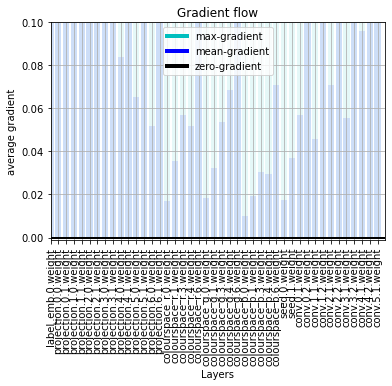

In [302]:
plot_grad_flow(gan.generator.named_parameters())

In [6]:
if False:
    ut.delete_gans_id(gan_id)
